# CNN Trainer
This notebook is designed for training and evaluating Convolutional Neural Networks (CNNs) on labeled image data.
It includes utilities for data preprocessing, dataset creation, model training, evaluation, and visualization of results, using PyTorch and related libraries. The goal is to facilitate experimentation with different CNN architectures and hyperparameters for supervised classification tasks in the provided datasets.


In [ ]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
sys.path.append(os.path.abspath(".."))
import utils.project_functions as pf
import utils.project_classes as pc
import utils.plot_training_resuilts as ptr
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label, center_of_mass
import vtk
import pandas as pd
import datetime
import pickle


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Manual data labeling

In [ ]:
# This is a test experiment with U=60, L=96, experiment="A"
# More data can be accessed from the following DOI:
# doi: 10.17632/44kc8zdxgr.1

U=60
L=96
frame=range(1,16)
e="A"

for f in frame:
    experiment = f"MAI_U{str(U).zfill(3)}_L_{str(L).zfill(3)}_{e}" 
    frame = f"mpcd_{f}"
    file_path = f"../Data/{experiment}/{frame}.vtk"
    output_path = f"../LabeledDataV2/{experiment}_{frame}_tensors.pkl"

    eigen_vals, eigen_vecs = pf.load_and_pad_vtk(file_path)
    winding_number, _ = pf.calculate_winding_number(eigen_vecs,pad_width=3)
    centroids = pf.find_candidates_by_winding_number(winding_number)
    centroids = np.array(centroids)
    centroids = centroids[:, [1,0]] # Swap columns to invert x,y coordinates

    labels, tensors = pf.create_label_tensor_data(eigen_vals, eigen_vecs, centroids, winding_number)
    pf.save_tensor_data(tensors, labels, centroids, output_path)


# Model training

In [ ]:
dir = "../LabeledData/"

model_save_path = "../Models"
model_save_name = f"cnn_{datetime.now().strftime('%Y-%m-%d')}.pth"
ignore_unknown = True


# Model Config
epochs = 50
batch_size = 64
learning_rate = 0.001
weight_decay = 0.0001
seed = 42

output_labels = 3 if ignore_unknown else 4

tensors2, labels2, encoded_labels2, positions2 =  pf.create_dataset(dir, ignore_unknown, is_unlabeled=False)

encoded_labels = torch.tensor(encoded_labels2, dtype=torch.long)

tensors = torch.tensor(tensors2, dtype=torch.float32).to(device)
encoded_labels = torch.tensor(encoded_labels2, dtype=torch.long).to(device)

print(tensors.shape)
print(encoded_labels.shape)
print("Labels: ", np.unique(labels2)) 


torch.Size([1985, 5, 7, 7])
torch.Size([1985])
Labels:  ['+' '-' '0']


In [4]:
unique_labels, counts = np.unique(labels2, return_counts=True)
label_counts = dict(zip(unique_labels, counts))

print("Label counts:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} entries")


Label counts:
Label +: 705 entries
Label -: 637 entries
Label 0: 643 entries


In [3]:

# Set the seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

dataset = pc.TensorDataset(tensors, encoded_labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = pc.CNNClassifier()
model = model.to(device)

# Compute class weights for imbalanced dataset
class_counts = torch.bincount(encoded_labels)
class_weights = 1.0 / class_counts.float()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [4]:
# Train and evaluate the model
training_history = pf.train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device)

              precision    recall  f1-score   support

           +       0.79      0.83      0.81       140
           -       0.75      0.88      0.81       133
           0       0.76      0.58      0.66       124

    accuracy                           0.77       397
   macro avg       0.77      0.76      0.76       397
weighted avg       0.77      0.77      0.76       397

Epoch 1/50, Train Loss: 22.4986, Val Loss: 5.2707, Train F1: 0.5878, Val F1: 0.7595
              precision    recall  f1-score   support

           +       0.93      0.91      0.92       140
           -       0.90      0.92      0.91       133
           0       0.84      0.83      0.83       124

    accuracy                           0.89       397
   macro avg       0.89      0.89      0.89       397
weighted avg       0.89      0.89      0.89       397

Epoch 2/50, Train Loss: 12.3444, Val Loss: 2.5788, Train F1: 0.8201, Val F1: 0.8874
              precision    recall  f1-score   support

           +   

In [16]:
train_preds, train_labels, val_preds, val_labels = ptr.get_predictions(model, train_loader, val_loader, device)
metrics = ptr.calculate_metrics(train_labels, train_preds, val_labels, val_preds)

# Define the filename for saving metadata
metadata_filename = os.path.join(model_save_path, model_save_name.replace('.pth', '_metadata.pkl'))

# Create a dictionary to store the metadata
metadata = {
    'train_preds': train_preds,
    'train_labels': train_labels,
    'val_preds': val_preds,
    'val_labels': val_labels,
    'metrics': metrics,
    'training_history':training_history
}

# Save the metadata to a file
with open(metadata_filename, 'wb') as f:
    pickle.dump(metadata, f)

print(f"Metadata saved to {metadata_filename}")


Metadata saved to ../Models/cnn_2025-08-12_metadata.pkl


In [6]:
metadata_filename = os.path.join(model_save_path, model_save_name.replace('.pth', '_metadata.pkl'))

with open(metadata_filename, 'rb') as f:
    metadata = pickle.load(f)

<Axes: title={'center': 'Precision-Recall Curves (Validation Set)'}, xlabel='Recall', ylabel='Precision'>

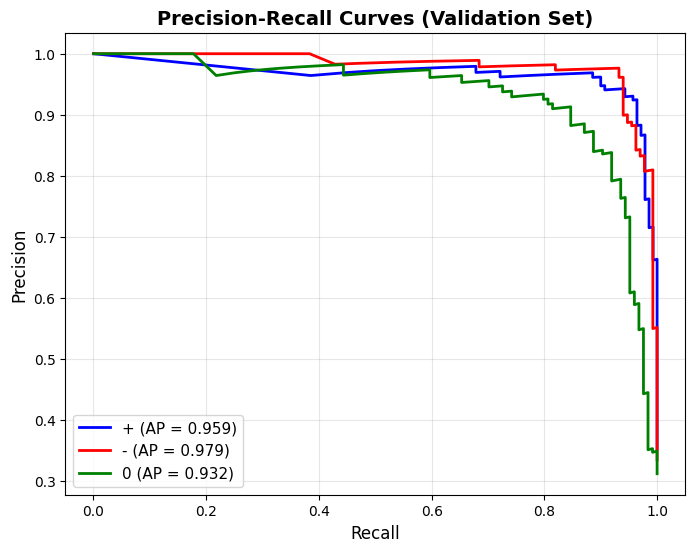

In [8]:
ptr.plot_precision_recall_curves(model, val_loader, device)

In [9]:
def get_pr_values(model, val_loader, device, ax=None):
    """
    Plot precision-recall curves for each class (important for imbalanced data).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Get probability predictions for PR curves
    all_probs = []
    all_true_labels = []
    
    model.eval()
    with torch.no_grad():
        for tensors, labels in val_loader:
            tensors = tensors.to(device)
            outputs = model(tensors)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    
    all_probs = np.array(all_probs)
    all_true_labels = np.array(all_true_labels)
    
    # Plot PR curves for each class
    colors = ['blue', 'red', 'green']
    class_names = ['+', '-', '0']
    
    # for i, (color, class_name) in enumerate(zip(colors, class_names)):
    #     binary_labels = (all_true_labels == i).astype(int)
        
    #     if len(np.unique(binary_labels)) > 1:
            
    #         precision, recall, _ = precision_recall_curve(binary_labels, all_probs[:, i])
    #         ap = average_precision_score(binary_labels, all_probs[:, i])
            
    #         ax.plot(recall, precision, color=color, lw=2, 
    #                label=f'{class_name} (AP = {ap:.3f})')
    
    
    return all_probs, all_true_labels

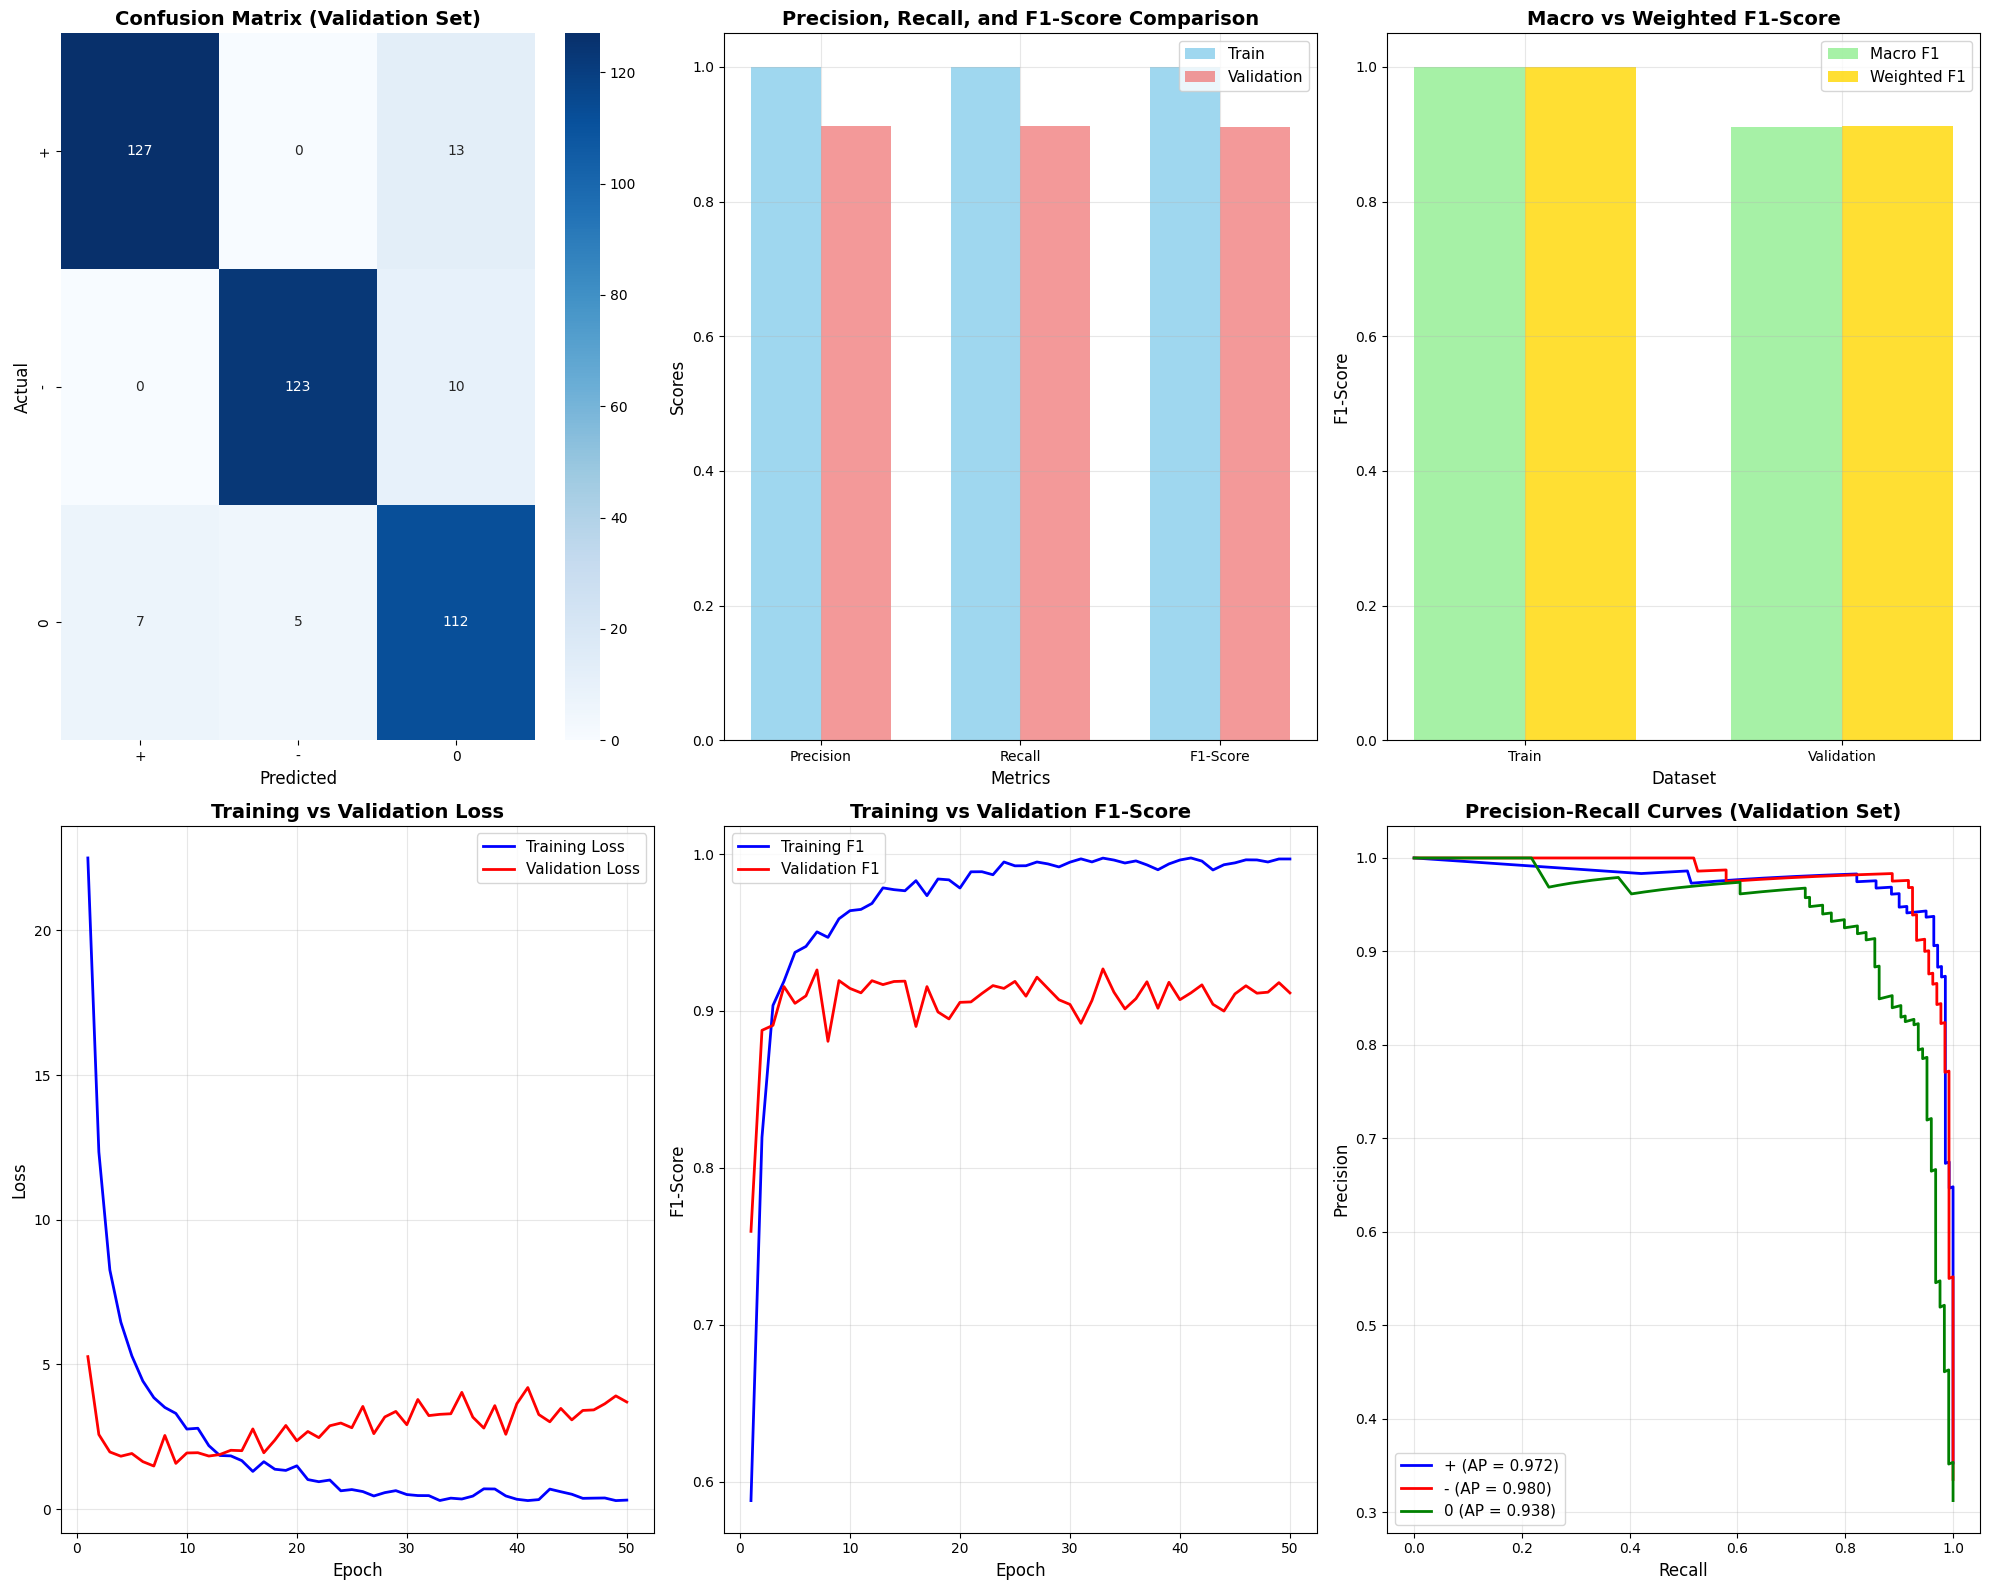


📊 TRAINING RESULTS SUMMARY
Training Set - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Validation Set - Precision: 0.9128, Recall: 0.9117, F1: 0.9115

Weighted F1 Scores:
Training: 1.0000, Validation: 0.9128


{'train_metrics': (1.0, 1.0, 1.0, 1.0),
 'val_metrics': (0.9127761078864934,
  0.9117268978898859,
  0.9114669665890406,
  0.9127974483126798)}

In [5]:
ptr.plot_training_results(model, train_loader, val_loader, criterion, device, training_history)

In [9]:
# Save the model    
torch.save(model.state_dict(), os.path.join(model_save_path, model_save_name))
